In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

2024-08-11 14:18:28.864437: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-11 14:18:28.891871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 14:18:29.301187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Input staging function Declarations

In [2]:
def getTripeptideColumn(df, tripeptide_list):
    '''
    
    '''
    Significance_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
            tripeptides = list()

    # First Amino Acid
            if i == uniprot_df.index[0]:

                    """ [A]-T-C-Y-K-P-Y-L
                         0  1 2 3 4 5 6 7
                    
                    Should only return ATC
                    
                    """
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at if statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,1]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,0]

    # Second Amino Acid
            elif i == uniprot_df.index[1]:

                    """  A-[T]-C-Y-K-P-Y-L
                         0  1  2 3 4 5 6 7
                    
                    Should only return ATC and TCY
                    
                    """
                    
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at elif #1 statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,1]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0]
                    
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at elif #2 statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)

    # Last Amino Acid
            elif i == uniprot_df.index[-1]:
                    
                    """  A-T-C-Y-K-P-Y-[L]
                         0 1 2 3 4-3-2 -1
                         
                    Should only return PYL
                    
                    """
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at elif #3 statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.at[i, 'tripeptide_significance'] = [1,0,0]

                        else:
                            uniprot_df.at[i, 'tripeptide_significance'] = [0,0,0]

    # Second Last Amino Acid
            elif i == uniprot_df.index[-2]:
                    
                    """  A-T-C-Y-K-P-[Y]-L
                         0 1 2 3 4-3 -2 -1
                         
                    Should only return PYL and KPY
                    
                    """
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at elif #4 statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [1]

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [0]
                    
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at elif #2 statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                            

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
    # All Other AAs
            else: 
                    
                    tripeptide = uniprot_df.loc[i-2:i,'amino_acid'].values
                    
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at else #1 statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [1]

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'] = [0]
                        
                    tripeptide = uniprot_df.loc[i-1:i+1,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at else #2 statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
                        
                    tripeptide = uniprot_df.loc[i:i+2,'amino_acid'].values
                    if len(tripeptide) != 3: 
                        sys.stderr.write(f"{tripeptide}\tERROR!!!! at else #3 statement.\n")
                    else:
                        tripeptide = [''.join(tripeptide)]
                        if tripeptide in tripeptide_list:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(1)

                        else:
                            uniprot_df.loc[i, 'tripeptide_significance'].append(0)
        
        Significance_df = pd.concat([Significance_df ,uniprot_df], ignore_index=True)

    return(Significance_df)
                        

In [3]:
def getAA_column(df):
    '''

    '''

    vectorised_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
    # Positively Charged AAs
    # Arginine - Pos 1
            if uniprot_df.loc[i, 'amino_acid'] == 'R':
                i_list = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Histidine - Pos 2
            elif uniprot_df.loc[i, 'amino_acid'] == 'H':
                i_list = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector
                
    # Lysine - Pos 3
            elif uniprot_df.loc[i, 'amino_acid'] == 'K':
                i_list = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Negatively Charged AAs
    # Aspartic Acid - Pos 4
            elif uniprot_df.loc[i, 'amino_acid'] == 'D':
                i_list = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Glutamic Acid - Pos 5
            elif uniprot_df.loc[i, 'amino_acid'] == 'E':
                i_list = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Polar Uncharged AAs
    # Serine - Pos 6
            elif uniprot_df.loc[i, 'amino_acid'] == 'S':
                i_list = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Threonine - Pos 7 
            elif uniprot_df.loc[i, 'amino_acid'] == 'T':
                i_list = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Asparagine  - Pos 8 
            elif uniprot_df.loc[i, 'amino_acid'] == 'N':
                i_list = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Glutamine - Pos 9 
            elif uniprot_df.loc[i, 'amino_acid'] == 'Q':
                i_list = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Special cases - come back to this
    # Glycine - Pos 10
            elif uniprot_df.loc[i, 'amino_acid'] == 'G':
                i_list = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Proline - Pos 11
            elif uniprot_df.loc[i, 'amino_acid'] == 'P':
                i_list = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Cysteine - Pos 12
            elif uniprot_df.loc[i, 'amino_acid'] == 'C':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Hydrophobic AAs
    # Alanine - Pos 13
            elif uniprot_df.loc[i, 'amino_acid'] == 'A':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Valine - Pos 14
            elif uniprot_df.loc[i, 'amino_acid'] == 'V':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Isoleucine - Pos 15
            elif uniprot_df.loc[i, 'amino_acid'] == 'I':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Leucine - Pos 16
            elif uniprot_df.loc[i, 'amino_acid'] == 'L':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Methionine - Pos 17
            elif uniprot_df.loc[i, 'amino_acid'] == 'M':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Phenylalanine - Pos 18
            elif uniprot_df.loc[i, 'amino_acid'] == 'F':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector
        
    # Tyrosine - Pos 19
            elif uniprot_df.loc[i, 'amino_acid'] == 'Y':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Tryptophan - Pos 20
            elif uniprot_df.loc[i, 'amino_acid'] == 'W':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector

    # Empty Position - Pos Null
            elif uniprot_df.loc[i, 'amino_acid'] == '-':
                i_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                i_vector = np.array(i_list)
                uniprot_df.at[i, 'amino_acid_vector'] = i_vector


            else:
                print("Mahoraga HELP ME")

        vectorised_df = pd.concat([vectorised_df ,uniprot_df], ignore_index=True)
    return vectorised_df

In [4]:
def getGT_column(df):
    '''
    
    '''
    GT_df = pd.DataFrame()
    # Iterate over rows in the data frame
    uniprot_ids = sorted(set(df.loc[:,'ID']))
    for uniprot_id in uniprot_ids:
        uniprot_df = df[df['ID'] == uniprot_id]
        residue_numbers = uniprot_df['residue_number'].values
        for i in uniprot_df.index:
            if uniprot_df.loc[i, 'Distance_to_RNA'] > 4.2:
                uniprot_df.at[i, 'binding_ground_truth'] = [0]

            elif uniprot_df.loc[i, 'Distance_to_RNA'] <= 4.2:
                uniprot_df.at[i, 'binding_ground_truth'] = [1]

            else:
                sys.stderr.write(f"Non-Integer Input within Distance_to_RNA column")

        GT_df = pd.concat([GT_df, uniprot_df], ignore_index=True)

    return GT_df
            

In [5]:
def training_data_preprocess(df, implicated_tripeptide_list):
    req_columns = ["No", "ID", 'pdb_id', 'residue_number', 'amino_acid', 'Distance_to_RNA']

    tripeptide_ready_data = df[req_columns]
    tripeptide_ready_data['tripeptide_significance'] = pd.NA
    tripeptide_ready_data['amino_acid_vector'] = pd.NA
    tripeptide_ready_data['binding_ground_truth'] = pd.NA

    post_tripeptide_df = getTripeptideColumn(tripeptide_ready_data, implicated_tripeptide_list)

    aa_vectorised_df = getAA_column(post_tripeptide_df)

    finalised_gt_df = getGT_column(aa_vectorised_df)

    resorted_finalsed_df = finalised_gt_df.sort_values(by='No', ascending = True)

    final_columns = ['ID','amino_acid_vector', 'tripeptide_significance', 'binding_ground_truth']
    
    model_input_final = resorted_finalsed_df[final_columns]

    return model_input_final

### Input Vector Staging

In [6]:
training_data = pd.read_csv('All_combined_results.txt', sep='\t')

In [7]:
top20_tripep_ordered = pd.read_csv('Top20_tripeptides_ordered.csv')
top20_tripep_disordered = pd.read_csv('Top20_tripeptides_disordered.csv')

top20_tripep_combined = pd.concat([top20_tripep_ordered, top20_tripep_disordered], ignore_index= True)
top20_tripep_combined.rename(columns={'0': 'tripeptides'}, inplace= True)

significant_tripeptides = top20_tripep_combined['tripeptides'].values
significant_tripeptides = significant_tripeptides.tolist()


In [8]:
completed_input_df = training_data_preprocess(training_data, significant_tripeptides)
completed_input_df['binding_ground_truth'] = completed_input_df['binding_ground_truth'].apply(lambda x: x[0])

/tmp/ipykernel_2715793/607325653.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripeptide_ready_data['tripeptide_significance'] = pd.NA
/tmp/ipykernel_2715793/607325653.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripeptide_ready_data['amino_acid_vector'] = pd.NA
/tmp/ipykernel_2715793/607325653.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [28]:
uniprot_ids = sorted(set(training_data.loc[:,'ID']))
len(uniprot_ids)

371

In [12]:
print(completed_input_df)

           ID                                  amino_acid_vector  \
29181  P23396  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
29182  P23396  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
29183  P23396  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
29184  P23396  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
29185  P23396  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
...       ...                                                ...   
96947  Q9Y580  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
96948  Q9Y580  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
96949  Q9Y580  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
96950  Q9Y580  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
96951  Q9Y580  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

      tripeptide_significance  binding_ground_truth  
29181               [0, 0, 0]                     0  
29182               [0, 0, 0]                     0  
29183               [

In [9]:
# Assuming 'amino_acid_vector' needs to be expanded
amino_acid_df = pd.DataFrame(completed_input_df['amino_acid_vector'].tolist(), index=completed_input_df.index)
amino_acid_df.columns = [f'amino_acid_{i}' for i in range(1,len(amino_acid_df.columns)+1)]  # Optional: Naming columns

tripeptide_df = pd.DataFrame(completed_input_df['tripeptide_significance'].tolist(), index=completed_input_df.index)
tripeptide_df.columns = [f'tri_peptide_aa_{i}' for i in range(1,len(tripeptide_df.columns)+1)]  # Optional: Naming columns

# Now join this back to the original dataframe if necessary
df_expanded = completed_input_df.join(amino_acid_df)
df_expanded = df_expanded.join(tripeptide_df)
df_expanded.drop(columns=['amino_acid_vector','tripeptide_significance'], axis=1, inplace=True)

In [10]:
df_expanded

,ID,binding_ground_truth,amino_acid_1,amino_acid_2,amino_acid_3,amino_acid_4,amino_acid_5,amino_acid_6,amino_acid_7,amino_acid_8,...,amino_acid_14,amino_acid_15,amino_acid_16,amino_acid_17,amino_acid_18,amino_acid_19,amino_acid_20,tri_peptide_aa_1,tri_peptide_aa_2,tri_peptide_aa_3
29181,P23396,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
29182,P23396,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29183,P23396,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
29184,P23396,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29185,P23396,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96947,Q9Y580,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96948,Q9Y580,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
96949,Q9Y580,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96950,Q9Y580,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [13]:
df_expanded.to_csv('Test_Model_02_Training_data.txt',sep='\t')

In [2]:
df_expanded = pd.read_csv('Test_Model_02_Training_data.txt', sep='\t')

In [4]:
df_expanded

,Unnamed: 0,ID,binding_ground_truth,amino_acid_1,amino_acid_2,amino_acid_3,amino_acid_4,amino_acid_5,amino_acid_6,amino_acid_7,...,amino_acid_14,amino_acid_15,amino_acid_16,amino_acid_17,amino_acid_18,amino_acid_19,amino_acid_20,tri_peptide_aa_1,tri_peptide_aa_2,tri_peptide_aa_3
0,29181,P23396,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,29182,P23396,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,29183,P23396,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,29184,P23396,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29185,P23396,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97712,96947,Q9Y580,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97713,96948,Q9Y580,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
97714,96949,Q9Y580,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97715,96950,Q9Y580,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Reshaping the data to make it compatible with a CNN:

In [5]:
# Assuming df_expanded is your final DataFrame after preprocessing
features = df_expanded.drop(['binding_ground_truth', 'ID','Unnamed: 0'], axis=1)  # ID is also not a feature
labels = df_expanded['binding_ground_truth']

# Convert DataFrame to numpy arrays
X = features.values
y = labels.values

# Reshape X to fit the CNN input shape (batch_size, height, width, channels)
# For 1D sequence data, you could treat each feature as a channel:
X = X.reshape((X.shape[0], 1, X.shape[1], 1))  # Height = 1, Width = number of features, Channels = 1

### Splitting the data:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Training the model 

In [7]:
model = Sequential([
    Conv2D(32, (1, 3), activation='relu', input_shape=(1, X_train.shape[2], 1)),  # Adjust the input shape and kernel
    MaxPooling2D(pool_size=(1, 2)),
    Flatten(),  # Flatten converts the 3D output to 1D for input to the fully connected layers
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now, let's check the model summary to understand its architecture
model.summary()

/home/pyrbdome/anaconda3/envs/pyrbdome/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-11 14:08:44.778486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-11 14:08:44.789949: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for ho

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1, 21, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 10, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,737 (81.00 KB)

 Trainable params: 20,737 (81.00 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting the model:

In [8]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 2s 956us/step - accuracy: 0.8841 - loss: 0.3493 - val_accuracy: 0.8865 - val_loss: 0.3371
Epoch 2/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 2s 930us/step - accuracy: 0.8872 - loss: 0.3362 - val_accuracy: 0.8865 - val_loss: 0.3382
Epoch 3/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step - accuracy: 0.8909 - loss: 0.3285 - val_accuracy: 0.8865 - val_loss: 0.3395
Epoch 4/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.8889 - loss: 0.3318 - val_accuracy: 0.8865 - val_loss: 0.3374
Epoch 5/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 2s 922us/step - accuracy: 0.8901 - loss: 0.3285 - val_accuracy: 0.8865 - val_loss: 0.3385
Epoch 6/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step - accuracy: 0.8904 - loss: 0.3285 - val_accuracy: 0.8865 - val_loss: 0.3370
Epoch 7/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.8905 - loss: 0.3274 - val_accuracy: 0.8865 - val_loss: 0.3386
Epoch 8/10
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.8876 -

### Evaluate the model:

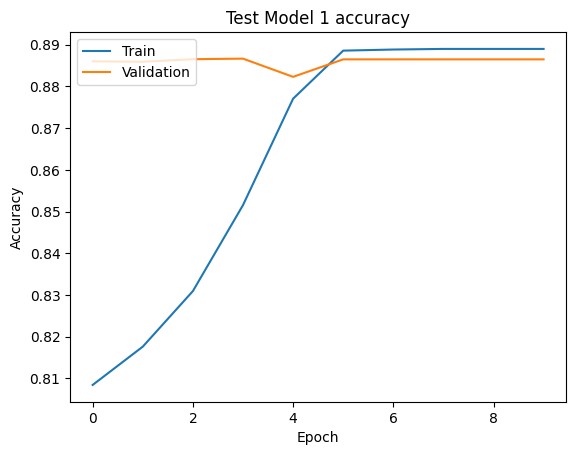

In [40]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])  # Ensure 'accuracy' is the right key; sometimes it could be 'acc'
plt.plot(history.history['val_accuracy'])  # Likewise, confirm if it should be 'val_accuracy' or 'val_acc'
plt.title('Test Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Model_01_Accuracy.png')
plt.show()

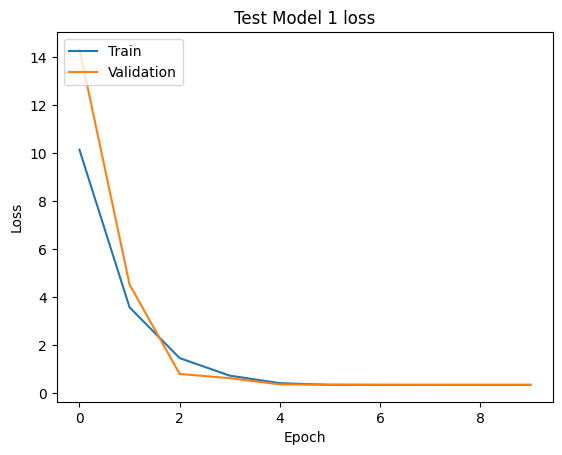

In [41]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('Test Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Model_01_Loss.png')
plt.show()

917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


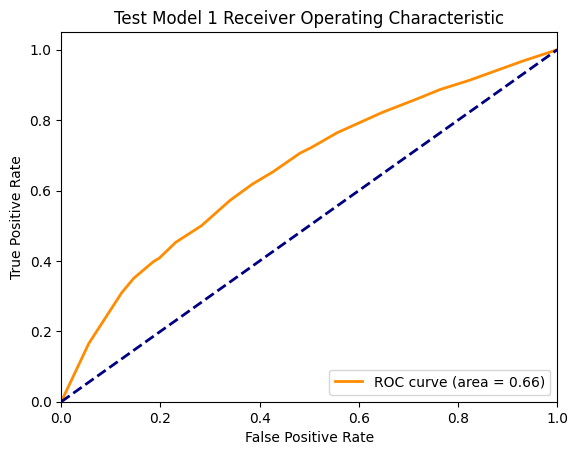

In [9]:
# Assume your model's prediction probabilities for the positive class are stored in y_scores
y_scores = model.predict(X_test)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Model 1 Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Model_01_ROC.png')
plt.show()


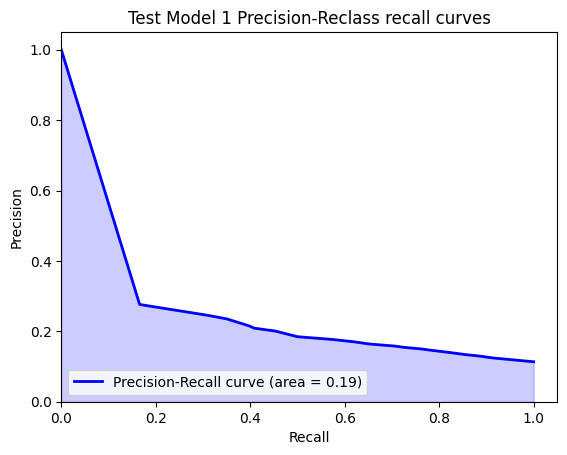

In [10]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Model 1 Precision-Reclass recall curves')
plt.legend(loc="lower left")
plt.savefig('Model_01_Recall.png')
plt.show()


### No-Tripep

In [4]:
df_expanded

,Unnamed: 0,ID,binding_ground_truth,amino_acid_1,amino_acid_2,amino_acid_3,amino_acid_4,amino_acid_5,amino_acid_6,amino_acid_7,...,amino_acid_14,amino_acid_15,amino_acid_16,amino_acid_17,amino_acid_18,amino_acid_19,amino_acid_20,tri_peptide_aa_1,tri_peptide_aa_2,tri_peptide_aa_3
0,29181,P23396,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,29182,P23396,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,29183,P23396,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,29184,P23396,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29185,P23396,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97712,96947,Q9Y580,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97713,96948,Q9Y580,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
97714,96949,Q9Y580,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97715,96950,Q9Y580,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
# Assuming df_expanded is your final DataFrame after preprocessing
features = df_expanded.drop(['binding_ground_truth', 'ID','Unnamed: 0', 'tri_peptide_aa_1', 'tri_peptide_aa_2', 'tri_peptide_aa_3'], axis=1)  # ID is also not a feature
labels = df_expanded['binding_ground_truth']

# Convert DataFrame to numpy arrays
X = features.values
y = labels.values

# Reshape X to fit the CNN input shape (batch_size, height, width, channels)
# For 1D sequence data, you could treat each feature as a channel:
X = X.reshape((X.shape[0], 1, X.shape[1], 1))  # Height = 1, Width = number of features, Channels = 1

In [9]:
features

,amino_acid_1,amino_acid_2,amino_acid_3,amino_acid_4,amino_acid_5,amino_acid_6,amino_acid_7,amino_acid_8,amino_acid_9,amino_acid_10,amino_acid_11,amino_acid_12,amino_acid_13,amino_acid_14,amino_acid_15,amino_acid_16,amino_acid_17,amino_acid_18,amino_acid_19,amino_acid_20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97712,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
97714,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
97715,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
model = Sequential([
    Conv2D(32, (1, 3), activation='relu', input_shape=(1, X_train.shape[2], 1)),  # Adjust the input shape and kernel
    MaxPooling2D(pool_size=(1, 2)),
    Flatten(),  # Flatten converts the 3D output to 1D for input to the fully connected layers
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now, let's check the model summary to understand its architecture
model.summary()

/home/pyrbdome/anaconda3/envs/pyrbdome/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-11 14:21:01.385421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-11 14:21:01.385766: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for ho

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1, 18, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,689 (73.00 KB)

 Trainable params: 18,689 (73.00 KB)

 Non-trainable params: 0 (0.00 B)

917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step


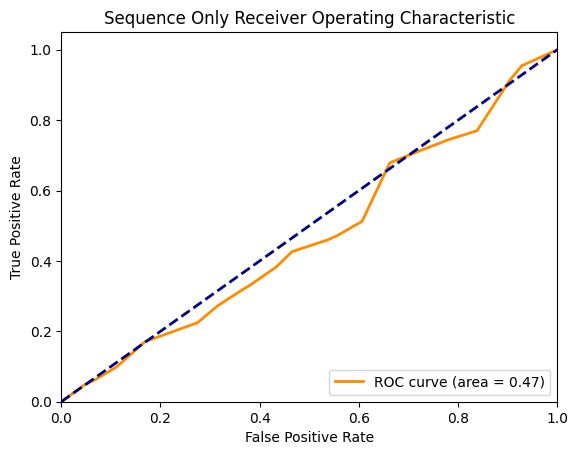

In [12]:
# Assume your model's prediction probabilities for the positive class are stored in y_scores
y_scores = model.predict(X_test)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sequence Only Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Model_01_ROC_noTri.png')
plt.show()


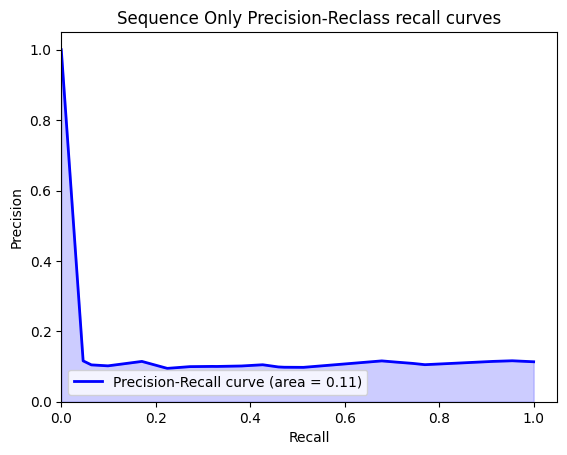

In [11]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sequence Only Precision-Reclass recall curves')
plt.legend(loc="lower left")
plt.savefig('Model_01_Recall_noTri.png')
plt.show()
